# all_songs_data_processed Decade Word Analysis

Analyze lyrics by decade (10-year bins): word frequency trends, top words, word count trends, and decade word clouds.

In [45]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Optional wordcloud; skip gracefully if missing
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print('wordcloud not installed; skipping word clouds.')


In [46]:
# Locate data path
data_dir_candidates = [Path('data') / 'song_info', Path('..') / 'data' / 'song_info']
for candidate in data_dir_candidates:
    if candidate.exists():
        data_dir = candidate
        break
else:
    raise FileNotFoundError('Could not find data/song_info directory')

csv_path = data_dir / 'all_songs_data_processed.csv'
csv_path

PosixPath('../data/song_info/all_songs_data_processed.csv')

In [47]:
# Load data and add decade column
df = pd.read_csv(csv_path)
df['Year_num'] = pd.to_numeric(df['Year'], errors='coerce')
df['Decade'] = (df['Year_num'] // 10 * 10).astype('Int64')

print(f'Rows: {len(df)}, Columns: {df.shape[1]}')
print('Columns:')
print(df.columns.tolist())


Rows: 6292, Columns: 20
Columns:
['Album', 'Album URL', 'Artist', 'Featured Artists', 'Lyrics', 'Media', 'Rank', 'Release Date', 'Song Title', 'Song URL', 'Writers', 'Year', 'Verbs', 'Nouns', 'Adverbs', 'Corpus', 'Word Counts', 'Unique Word Counts', 'Year_num', 'Decade']


,missing_count,missing_rate
Album,319,0.0507
Adverbs,96,0.0153
Verbs,49,0.0078
Nouns,43,0.0068
Corpus,24,0.0038
Lyrics,21,0.0033
Word Counts,0,0.0000
Unique Word Counts,0,0.0000
Year_num,0,0.0000
Decade,0,0.0000


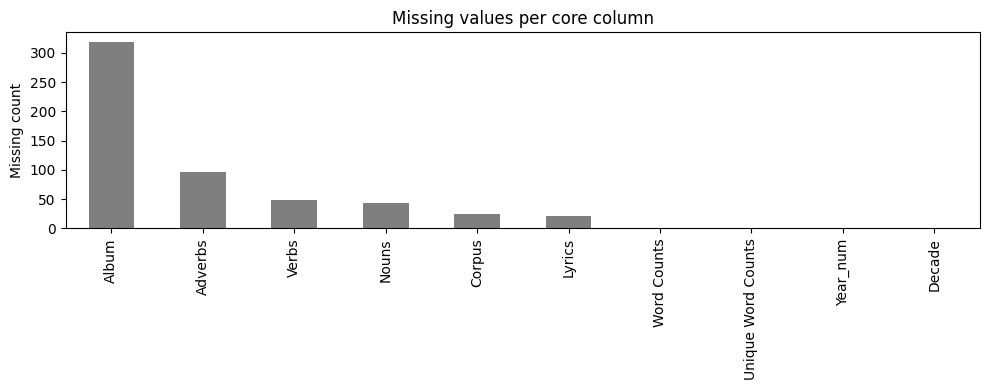

In [48]:
# Missing value summary for core columns
core_cols = ['Album', 'Lyrics', 'Verbs', 'Nouns', 'Adverbs', 'Corpus', 'Word Counts', 'Unique Word Counts', 'Year_num', 'Decade']
missing_counts = df[core_cols].isna().sum().sort_values(ascending=False)
missing_rate = (missing_counts / len(df)).round(4)
missing_summary = pd.DataFrame({'missing_count': missing_counts, 'missing_rate': missing_rate})
display(missing_summary)

plt.figure(figsize=(10, 4))
missing_counts.plot(kind='bar', color='tab:gray')
plt.title('Missing values per core column')
plt.ylabel('Missing count')
plt.tight_layout()
plt.show()


Samples per decade:


,count
Decade,
1950,90
1960,958
1970,963
1980,984
1990,965
2000,972
2010,981
2020,379


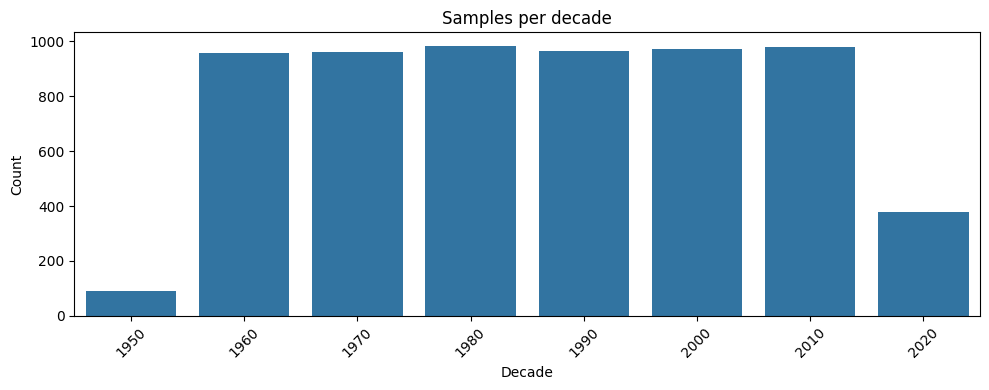

In [49]:
# Sample counts per decade
decade_counts = df['Decade'].value_counts().sort_index()
print('Samples per decade:')
display(decade_counts.to_frame('count'))

plt.figure(figsize=(10, 4))
sns.barplot(x=decade_counts.index.astype(str), y=decade_counts.values, color='tab:blue')
plt.title('Samples per decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
# Clean data: drop missing key fields, drop very short lyrics (<=2 words)
clean_cols = ['Lyrics', 'Verbs', 'Nouns', 'Adverbs', 'Corpus', 'Word Counts', 'Unique Word Counts', 'Year_num', 'Decade']
clean_df = df.dropna(subset=clean_cols).copy()
clean_df = clean_df[clean_df['Word Counts'] > 2]
print(f'Rows after cleaning: {len(clean_df)}')


Rows after cleaning: 6192


,Word Counts,Unique Word Counts
Decade,,
1950,197.88,87.69
1960,209.77,90.64
1970,255.74,101.77
1980,285.91,109.76
1990,392.43,148.68
2000,482.55,175.07
2010,444.61,158.66
2020,422.02,169.63


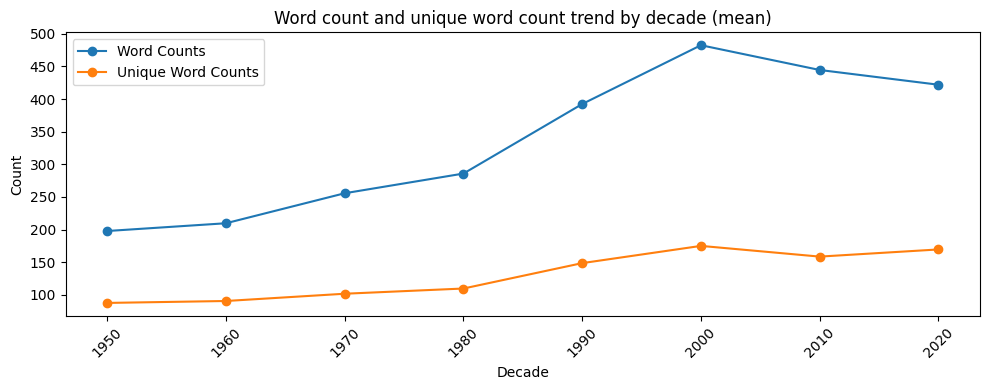

In [51]:
# Word count trend by decade (mean)
trend = clean_df.groupby('Decade')[['Word Counts', 'Unique Word Counts']].mean().round(2)
display(trend)

ax = trend.plot(kind='line', marker='o', figsize=(10, 4))
ax.set_title('Word count and unique word count trend by decade (mean)')
ax.set_ylabel('Count')
ax.set_xlabel('Decade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,love,oh,know,like,yeah,get,baby,go,come,let,want,to,time,girl,wanna,feel,ooh,way,tell,need
1950,217,117,84,60,102,75,121,98,102,28,73,54,52,40,17,46,51,26,50,16
1960,2697,1530,1364,744,1133,986,1600,1024,1235,781,578,675,704,772,153,350,410,506,600,423
1970,3815,1782,1525,1075,1125,1549,1604,1234,1229,945,809,850,920,583,347,700,880,761,603,546
1980,3892,2925,2407,1410,1301,1524,1687,1653,1261,1204,1396,1258,1400,833,706,1072,916,853,928,803
1990,4077,2048,3052,2166,2064,1977,2992,1748,1826,1556,1942,1502,1435,1035,1552,1257,565,1230,1091,1074
2000,3191,3528,4055,3975,2450,3197,2471,1967,1677,1993,1751,1593,1425,2398,1889,1262,1004,1416,1256,1086
2010,3000,5269,3443,4213,3990,3224,2489,1626,1530,2014,1701,1524,1247,1535,1511,1269,1845,1018,1281,1091
2020,837,1203,1126,1639,1818,1117,677,339,398,491,488,336,424,349,482,351,624,450,412,477


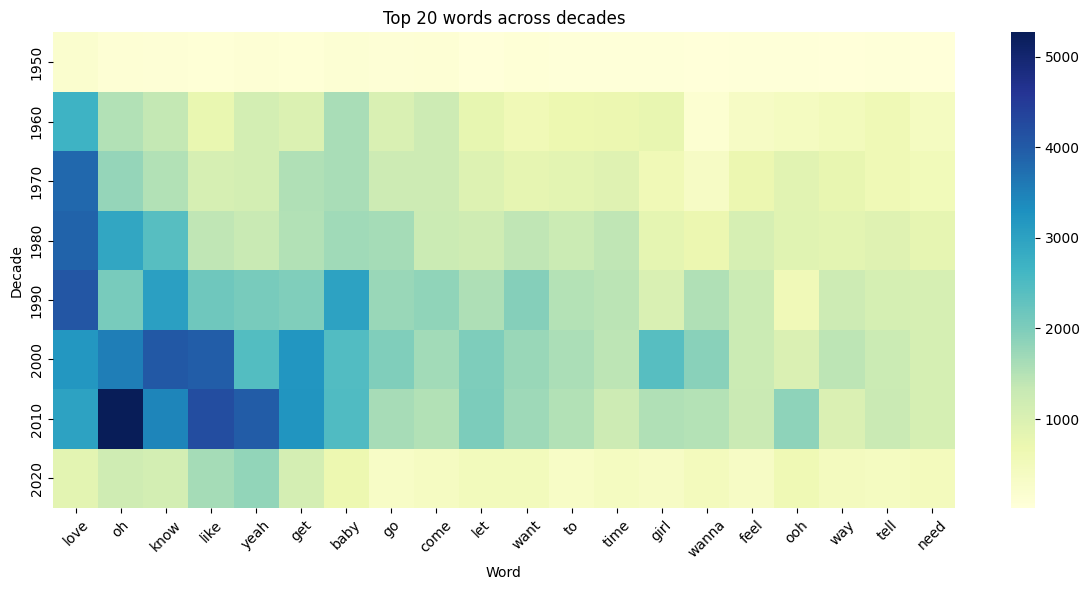

In [52]:
# High-frequency words across decades (based on Corpus)
def tokenize(text):
    return str(text).lower().split()

decade_counters = {}
overall_counter = Counter()
for decade, texts in clean_df.groupby('Decade')['Corpus']:
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    decade_counters[decade] = counter
    overall_counter.update(counter)

# Take global top 20 words and show counts per decade
top_words = [w for w, _ in overall_counter.most_common(20)]
decades = sorted(decade_counters.keys())
heat_df = pd.DataFrame({w: [decade_counters[d].get(w, 0) for d in decades] for w in top_words}, index=decades)
display(heat_df)

plt.figure(figsize=(12, 6))
sns.heatmap(heat_df, annot=False, cmap='YlGnBu')
plt.title('Top 20 words across decades')
plt.ylabel('Decade')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


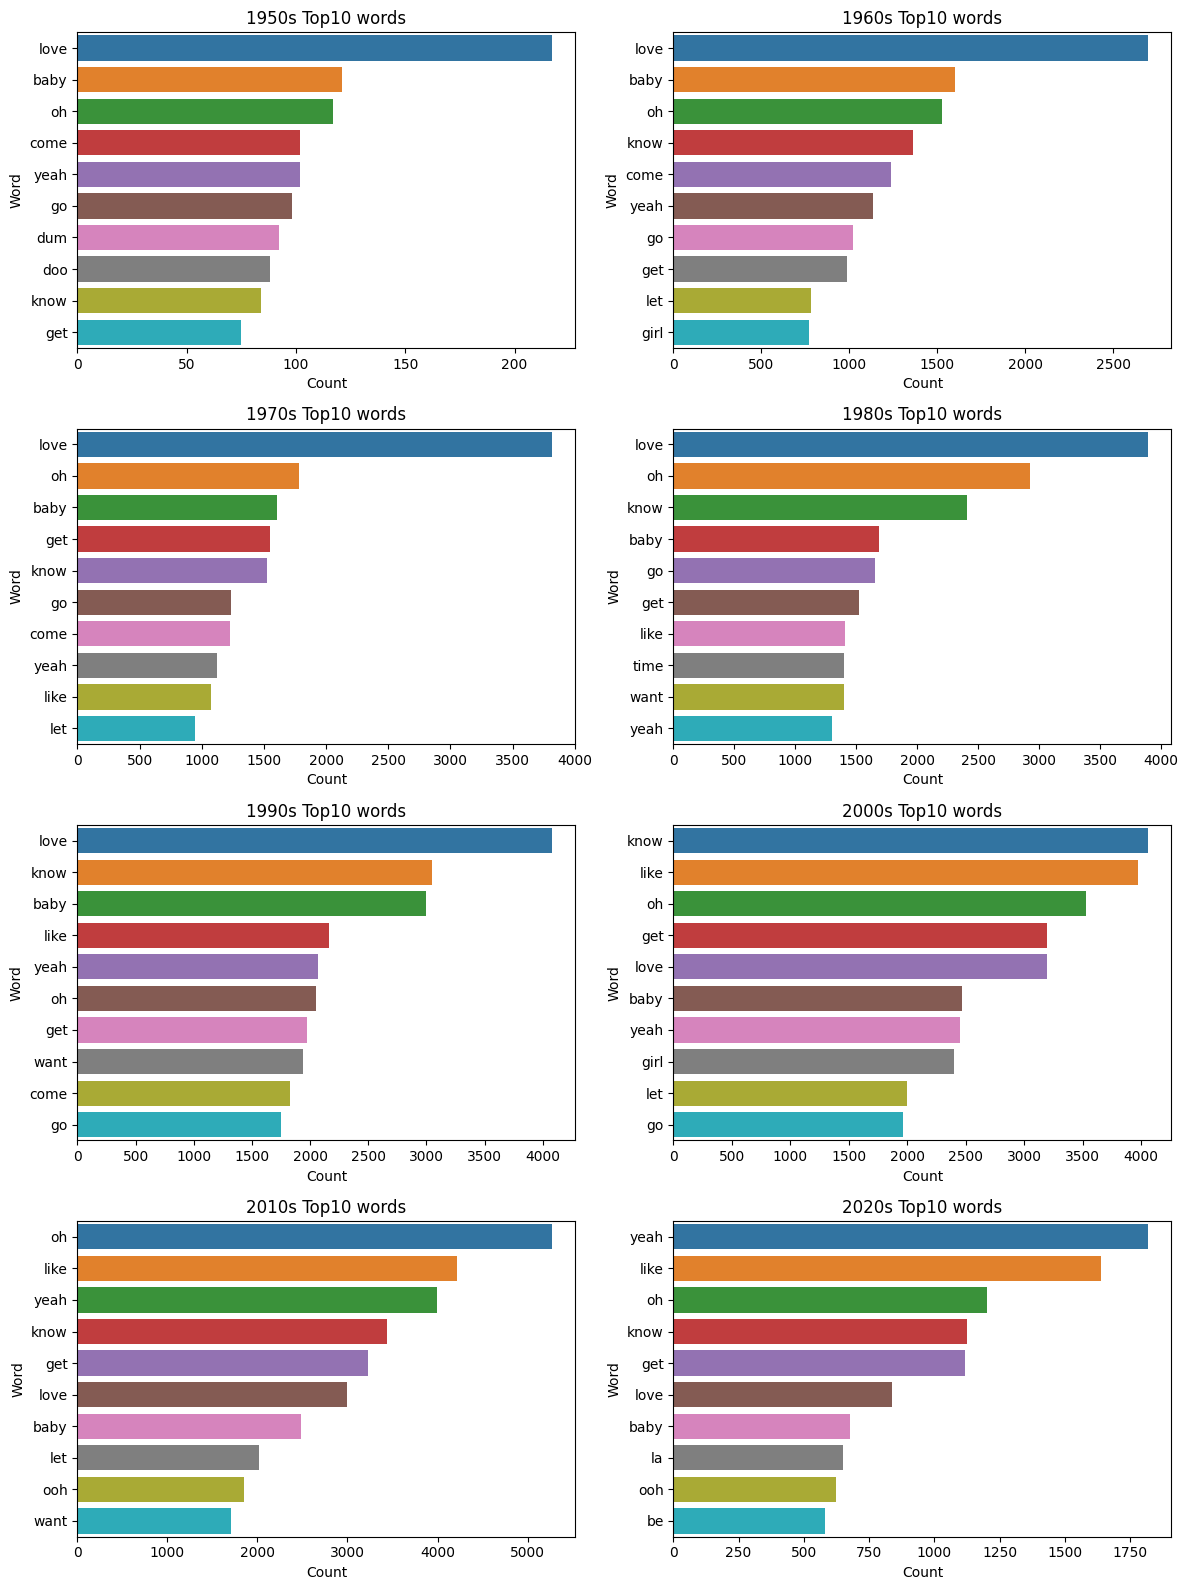

In [53]:
# 各年代Top10词条可视化
# Visualize top10 words per decade
top_per_decade = []
for decade in sorted(decade_counters.keys()):
    top10 = decade_counters[decade].most_common(10)
    top_per_decade.append({
        'Decade': decade,
        'Top10': top10
    })

top_df = pd.DataFrame(top_per_decade)

n_cols = 2
n_rows = int(np.ceil(len(top_df) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, top_df.iterrows()):
    words, counts = zip(*row['Top10']) if row['Top10'] else ([], [])
    palette = sns.color_palette('tab10', n_colors=len(words)) if words else None
    sns.barplot(x=list(counts), y=list(words), hue=list(words), palette=palette, ax=ax, dodge=False, legend=False)
    ax.set_title(f"{int(row['Decade'])}s Top10 words")
    ax.set_xlabel('Count')
    ax.set_ylabel('Word')

for ax in axes[len(top_df):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


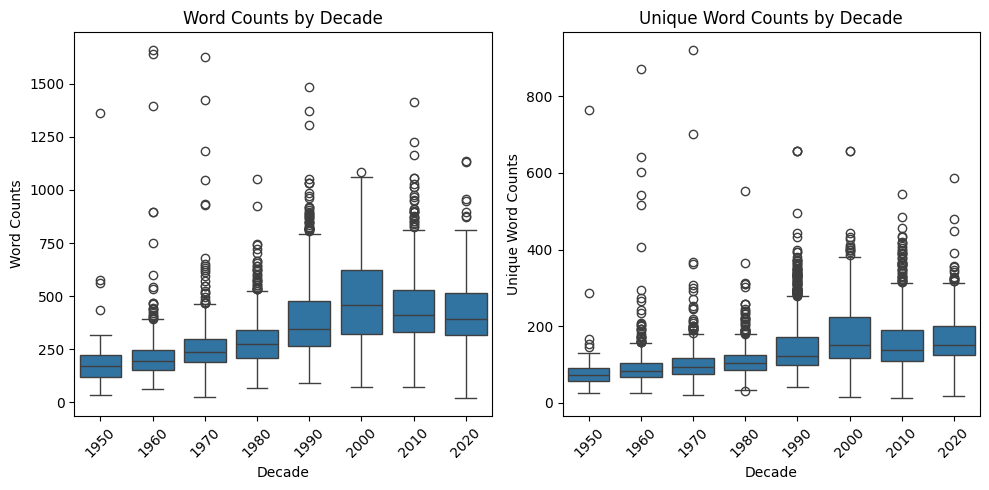

In [54]:
# Word Count / Unique Word Count boxplots by decade
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=clean_df, x='Decade', y='Word Counts')
plt.title('Word Counts by Decade')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=clean_df, x='Decade', y='Unique Word Counts')
plt.title('Unique Word Counts by Decade')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


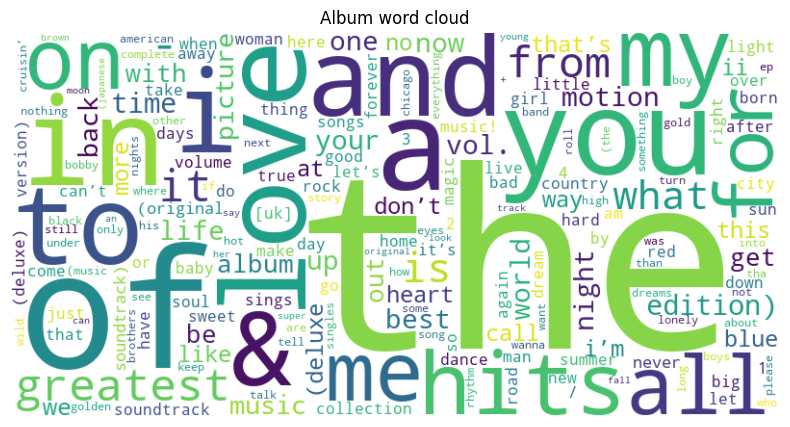

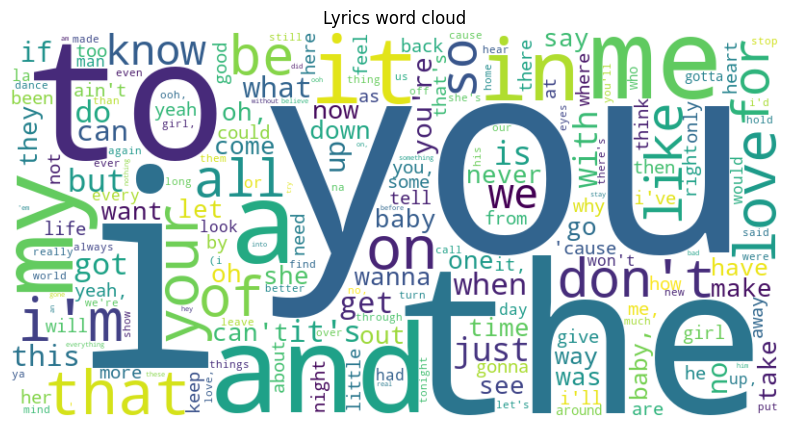

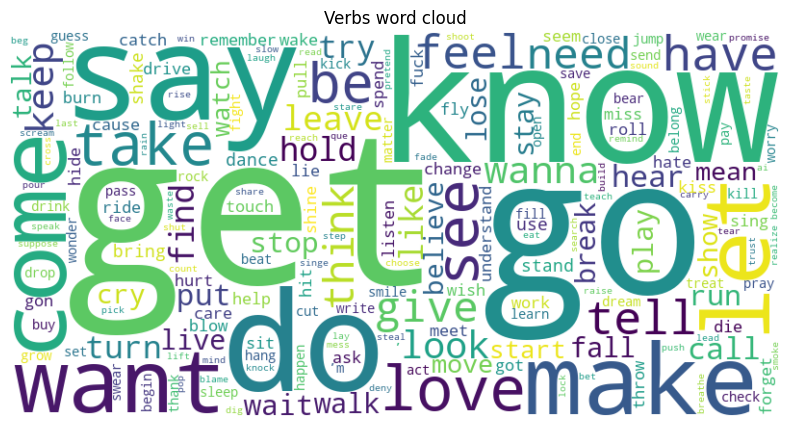

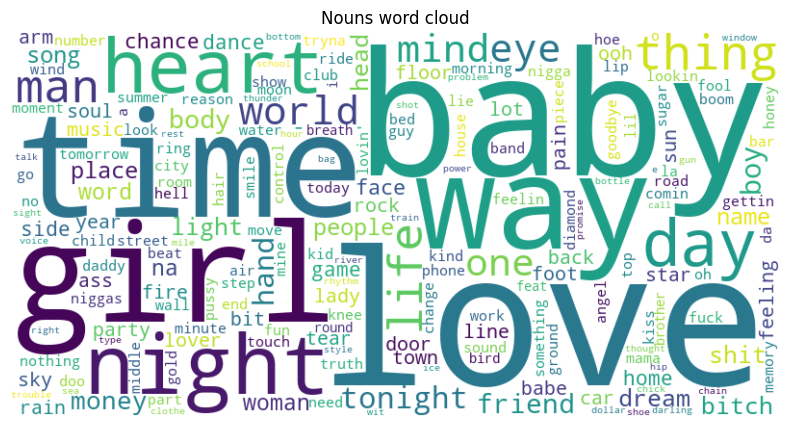

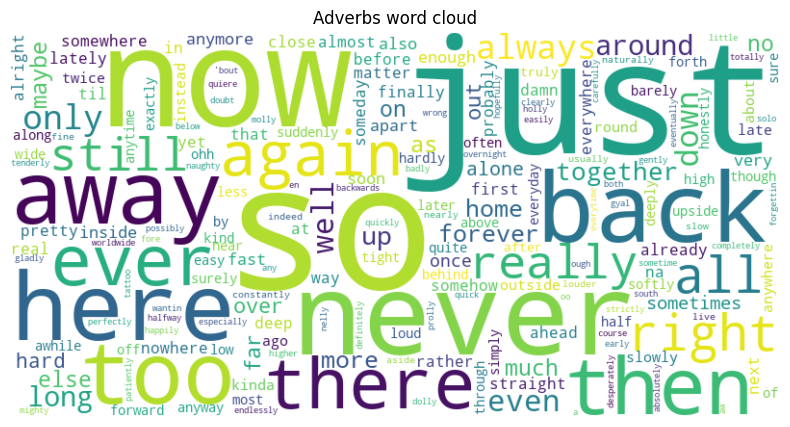

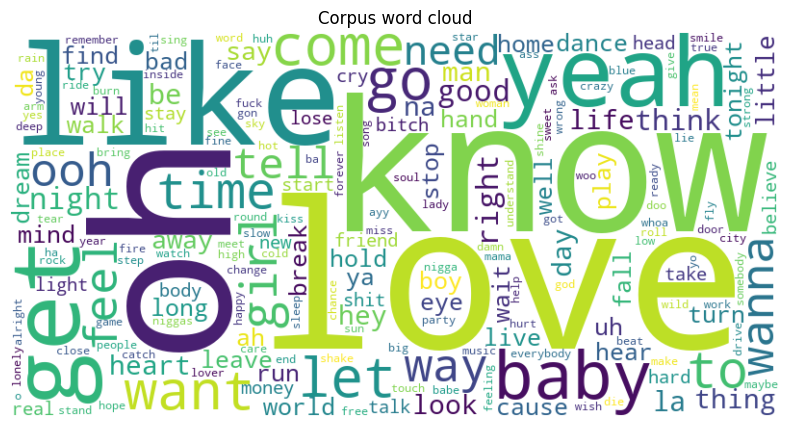

In [55]:
# wordcloud：按列生成整体词云（不含词数列）
# wordcloud: overall clouds for specified text columns
if not WORDCLOUD_AVAILABLE:
    print('wordcloud not installed; skipping word clouds.')
else:
    target_cols = ['Album', 'Lyrics', 'Verbs', 'Nouns', 'Adverbs', 'Corpus']
    text_cols = target_cols
    for col in target_cols:
        series = clean_df[col]
        tokens = series.dropna().astype(str).str.lower().str.split()
        freq = {}
        for tlist in tokens:
            for tok in tlist:
                freq[tok] = freq.get(tok, 0) + 1
        if not freq:
            print(f'Skip {col}: no data')
            continue
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'{col} word cloud')
        plt.axis('off')
        plt.show()
